In [5]:
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

from keyrover import *
from keyrover.vision import *
from keyrover.vision.models import TexcoordsRegressionModel
from keyrover.datasets import KeyboardTexcoordDataset

import wandb

wandb.login()
device

'mps'

In [6]:
SIZE = (256, 256)

train_dataset, valid_dataset, test_dataset = KeyboardTexcoordDataset.load("v4", size=SIZE, kind="tanh")
len(train_dataset), len(valid_dataset), len(test_dataset)

100%|██████████| 500/500 [00:03<00:00, 131.75it/s]


(4000, 499, 500)

<class 'torch.Tensor'> (torch.float32, shape=torch.Size([3, 256, 256]))
        Min: -1.0
        Max: 1.0
        Mean: -0.5855068564414978
<class 'torch.Tensor'> (torch.float32, shape=torch.Size([3, 256, 256]))
        Min: -1.23567533493042
        Max: 2.174588441848755
        Mean: 0.453567236661911


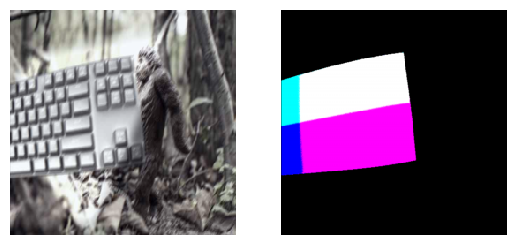

In [7]:
train_dataset.set_transforms([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    # transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
])

train_dataset.set_input_augmentations([
    # transforms.GaussianNoise(sigma=0.1, clip=True),
    # transforms.RandomApply([transforms.GaussianNoise(sigma=0.1, clip=False)], p=0.5),
], norm_params="default")

img, mask = train_dataset.random_img()
imshow(img, mask)

describe(mask)
describe(img)

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(train_dataset, valid_dataset, test_dataset,
                                                                         batch_size=48, num_workers=2,
                                                                         persistent_workers=True, pin_memory=True)

In [9]:
ARCH = "unet"
BACKBONE = "timm-regnety_002"

LEARNING_RATE = 2e-3

wandb.finish()
model = TexcoordsRegressionModel(ARCH, BACKBONE, in_channels=3, out_classes=2, encoder_weights="imagenet",
                                 lr=LEARNING_RATE, activation="tanh")
model

TexcoordsRegressionModel(
  (model): Unet(
    (encoder): RegNetEncoder(
      (stem): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (s1): RegStage(
        (b1): Bottleneck(
          (conv1): ConvNormAct(
            (conv): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
          )
          (conv2): ConvNormAct(
            (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            (bn): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, track_runni

In [10]:
summarize(model)

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | Unet    | 5.3 M  | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.037    Total estimated model params size (MB)
427       Modules in train mode
0         Modules in eval mode

In [ ]:
logger = WandbLogger(project="mrover-keyboard-texcoords-segmentation")

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [41]:
model.save(f"models/texcoords/{wandb.run.name}-{ARCH}-{BACKBONE}.pt")

tensor(-1.1417) tensor(2.9633)


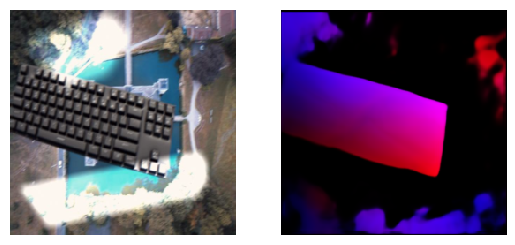

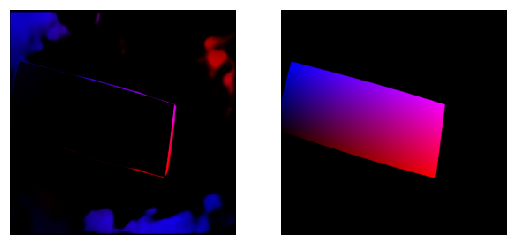

In [55]:
img, mask = valid_dataset.random_img()
pred = model.predict(img)

imshow(img, pred)
imshow((mask - pred) ** 2, mask)